# Data analytics final project

*Dominik Woźniak, 2022*

## Dataset
Dataset basing on golf putting data, typed in from Don Berry’s 1996 textbook. The columns are distance in feet from the hole, number of tries, and number of successes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,x,n,y
0,2,1443,1346
1,3,694,577
2,4,455,337
3,5,353,208
4,6,272,149


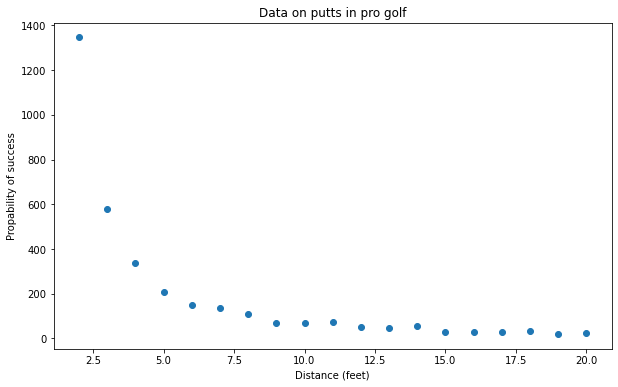

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(data.x, data.y)
plt.title('Data on putts in pro golf')
plt.xlabel('Distance (feet)')
plt.ylabel('Propability of success')
plt.show()

## Prepare data

In [5]:
import json
import os
import numpy as np
from cmdstanpy import write_stan_json

In [11]:
from src.types import StanInputNumber, StanInputList, StanInputValue, StanInput, CoordDict, PreparedData
from src.constants import DATA_DIR, STAN_INPUTS_DIR, MEASUREMENTS_FILE, INPUT_PRIOR_FILE, INPUT_POSTERIOR_FILE
from src.helpers import get_stan_input, get_stan_inputs, prepare_data

In [12]:
if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)
    
if not os.path.exists(STAN_INPUTS_DIR):
    os.mkdir(STAN_INPUTS_DIR)    

In [13]:
prepared_data = prepare_data(data)

In [14]:
prepared_data.measurements.to_csv(MEASUREMENTS_FILE)

In [15]:
si_prior, si_posterior, sis_cv = get_stan_inputs(prepared_data)

In [16]:
write_stan_json(INPUT_POSTERIOR_FILE, si_posterior)
write_stan_json(INPUT_PRIOR_FILE, si_prior)

In [18]:
for i, stan_input in enumerate(sis_cv):
    file_path = os.path.join(STAN_INPUTS_DIR, f"split_{str(i)}.json")
    write_stan_json(file_path, stan_input)